In [4]:
# !wget "https://github.com/mmalekzadeh/motion-sense/raw/master/data/A_DeviceMotion_data.zip" #get raw data
# !unzip A_DeviceMotion_data.zip.1
# wget https://raw.githubusercontent.com/mmalekzadeh/motion-sense/master/data/data_subjects_info.csv Get subject info

--2023-04-06 17:35:43--  https://raw.githubusercontent.com/mmalekzadeh/motion-sense/master/data/data_subjects_info.csv
Risoluzione di raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connessione a raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connesso.
Richiesta HTTP inviata, in attesa di risposta... 200 OK
Lunghezza: 385 [text/plain]
Salvataggio in: "data_subjects_info.csv"

data_subjects_info. 100%[===================>]     385  --.-KB/s    in 0s      

2023-04-06 17:35:43 (17,5 MB/s) - "data_subjects_info.csv" salvato [385/385]

--2023-04-06 17:35:43--  http://get/
Risoluzione di get (get)... non riuscito: nodename nor servname provided, or not known.
wget: impossibile risolvere l'indirizzo dell'host "get"
--2023-04-06 17:35:43--  http://subject/
Risoluzione di subject (subject)... non riuscito: nodename nor servname provided, or not known.
wget: impossibile risolvere l'indirizzo dell'host

In [ ]:
import numpy as np
import pandas as pd

def get_ds_infos():
    """
    Read the file includes data subject information.
    
    Data Columns:
    0: code [1-24]
    1: weight [kg]
    2: height [cm]
    3: age [years]
    4: gender [0:Female, 1:Male]
    
    Returns:
        A pandas DataFrame that contains inforamtion about data subjects' attributes 
    """ 

    dss = pd.read_csv("data_subjects_info.csv")
    print("[INFO] -- Data subjects' information is imported.")
    
    return dss

In [57]:
def set_data_types(data_types=["userAcceleration"]):
    """
    Select the sensors and the mode to shape the final dataset.
    
    Args:
        data_types: A list of sensor data type from this list: [attitude, gravity, rotationRate, userAcceleration] 

    Returns:
        It returns a list of columns to use for creating time-series from files.
    """
    dt_list = []
    for t in data_types:
        if t != "attitude":
            dt_list.append([t+".x",t+".y",t+".z"])
        else:
            dt_list.append([t+".roll", t+".pitch", t+".yaw"])

    return dt_list


def creat_time_series(dt_list, act_labels, trial_codes, mode="mag", labeled=True):
    """
    Args:
        dt_list: A list of columns that shows the type of data we want.
        act_labels: list of activites
        trial_codes: list of trials
        mode: It can be "raw" which means you want raw data
        for every dimention of each data type,
        [attitude(roll, pitch, yaw); gravity(x, y, z); rotationRate(x, y, z); userAcceleration(x,y,z)].
        or it can be "mag" which means you only want the magnitude for each data type: (x^2+y^2+z^2)^(1/2)
        labeled: True, if we want a labeld dataset. False, if we only want sensor values.

    Returns:
        It returns a time-series of sensor data.
    
    """
    num_data_cols = len(dt_list) if mode == "mag" else len(dt_list*3)

    if labeled:
        dataset = np.zeros((0,num_data_cols+7)) # "7" --> [act, code, weight, height, age, gender, trial] 
    else:
        dataset = np.zeros((0,num_data_cols))
        
    ds_list = get_ds_infos()
    
    print("[INFO] -- Creating Time-Series")
    for sub_id in ds_list["code"]:
        for act_id, act in enumerate(act_labels):
            for trial in trial_codes[act_id]:
                fname = 'A_DeviceMotion_data/'+act+'_'+str(trial)+'/sub_'+str(int(sub_id))+'.csv'
                raw_data = pd.read_csv(fname)
                raw_data = raw_data.drop(['Unnamed: 0'], axis=1)
                vals = np.zeros((len(raw_data), num_data_cols))
                for x_id, axes in enumerate(dt_list):
                    if mode == "mag":
                        vals[:,x_id] = (raw_data[axes]**2).sum(axis=1)**0.5        
                    else:
                        vals[:,x_id*3:(x_id+1)*3] = raw_data[axes].values
                    vals = vals[:,:num_data_cols]
                if labeled:
                    lbls = np.array([[act_id,
                            sub_id-1,
                            ds_list["weight"][sub_id-1],
                            ds_list["height"][sub_id-1],
                            ds_list["age"][sub_id-1],
                            ds_list["gender"][sub_id-1],
                            trial          
                           ]]*len(raw_data))
                    vals = np.concatenate((vals, lbls), axis=1)
                dataset = np.append(dataset,vals, axis=0)
    cols = []
    for axes in dt_list:
        if mode == "raw":
            cols += axes
        else:
            cols += [str(axes[0][:-2])]
            
    if labeled:
        cols += ["act", "id", "weight", "height", "age", "gender", "trial"]
    
    dataset = pd.DataFrame(data=dataset, columns=cols)
    return dataset


In [58]:


ACT_LABELS = ["dws","ups", "wlk", "jog", "std", "sit"]
TRIAL_CODES = {
    ACT_LABELS[0]:[1,2,11],
    ACT_LABELS[1]:[3,4,12],
    ACT_LABELS[2]:[7,8,15],
    ACT_LABELS[3]:[9,16],
    ACT_LABELS[4]:[6,14],
    ACT_LABELS[5]:[5,13]
}

## Here we set parameter to build labeld time-series from dataset of "(A)DeviceMotion_data"
## attitude(roll, pitch, yaw); gravity(x, y, z); rotationRate(x, y, z); userAcceleration(x,y,z)
sdt = ["rotationRate", "userAcceleration"]
print("[INFO] -- Selected sensor data types: "+str(sdt))    
act_labels = ACT_LABELS
print("[INFO] -- Selected activites: "+str(act_labels))    
trial_codes = [TRIAL_CODES[act] for act in act_labels]
dt_list = set_data_types(sdt)
dataset = creat_time_series(dt_list, act_labels, trial_codes, mode="raw", labeled=True)
print("[INFO] -- Shape of time-Series dataset:"+str(dataset.shape))    


[INFO] -- Selected sensor data types: ['rotationRate', 'userAcceleration']
[INFO] -- Selected activites: ['dws', 'ups', 'wlk', 'jog', 'std', 'sit']
[INFO] -- Data subjects' information is imported.
[INFO] -- Creating Time-Series
[INFO] -- Shape of time-Series dataset:(1412865, 13)


In [59]:
sub_data = dataset[(dataset["id"]==0) & (dataset["act"]==0) & (dataset["trial"]==1)]
print(sub_data.shape)
print(sub_data.head(5))

(1751, 13)
   rotationRate.x  rotationRate.y  rotationRate.z  userAcceleration.x  \
0        0.316738        0.778180        1.082764            0.294894   
1        0.842032        0.424446        0.643574            0.219405   
2       -0.138143       -0.040741        0.343563            0.010714   
3       -0.025005       -1.048717        0.035860           -0.008389   
4        0.114253       -0.912890        0.047341            0.199441   

   userAcceleration.y  userAcceleration.z  act   id  weight  height   age  \
0           -0.184493            0.377542  0.0  0.0   102.0   188.0  46.0   
1            0.035846            0.114866  0.0  0.0   102.0   188.0  46.0   
2            0.134701           -0.167808  0.0  0.0   102.0   188.0  46.0   
3            0.136788            0.094958  0.0  0.0   102.0   188.0  46.0   
4            0.353996           -0.044299  0.0  0.0   102.0   188.0  46.0   

   gender  trial  
0     1.0    1.0  
1     1.0    1.0  
2     1.0    1.0  
3     1.0  

In [61]:
# We want to get windowed data from time-series data
from tqdm import tqdm
def get_windowed_data(dataset, window_size=100, overlap=0):
    """
    Args:
        dataset: a pandas DataFrame that contains time-series of sensor data.
        window_size: the size of window.
        overlap: the overlap between two consecutive windows.

    Returns:
        It returns a list of windowed data.
    """
    rot_samples, acc_samples, act_labels, subj = [], [], [], []
    for sub_id in tqdm(dataset["id"].unique()):
        for act_id in dataset["act"].unique():
            for trial in dataset["trial"].unique():
                sub_data = dataset[(dataset["id"]==sub_id) & (dataset["act"]==act_id) & (dataset["trial"]==trial)]
                if len(sub_data) > window_size:
                    i = 0
                    while i < len(sub_data)-window_size:
                        rot_samples.append(sub_data.iloc[i:i+window_size,0:3].values)
                        acc_samples.append(sub_data.iloc[i:i+window_size,3:6].values)
                        act_labels.append(act_id)
                        subj.append(sub_id)
                        i = int(i + np.floor(window_size*(1-overlap)))
    rot_samples = np.asarray(rot_samples)
    acc_samples = np.asarray(acc_samples)
    act_labels = np.asarray(act_labels)
    subj = np.asarray(subj)
    print(f"Accelerometer data: {acc_samples.shape}")
    print(f"RotationRate data: {rot_samples.shape}")
    print(f"Labels data: {act_labels.shape}")
    print(f"Subjects data: {subj.shape}")
    return rot_samples, acc_samples, act_labels, subj

In [62]:
rot_samples, acc_samples, act_labels, subj = get_windowed_data(dataset, overlap=0.5)

100%|██████████| 24/24 [00:24<00:00,  1.03s/it]

Accelerometer data: (27712, 100, 3)
RotationRate data: (27712, 100, 3)
Labels data: (27712,)
Subjects data: (27712,)


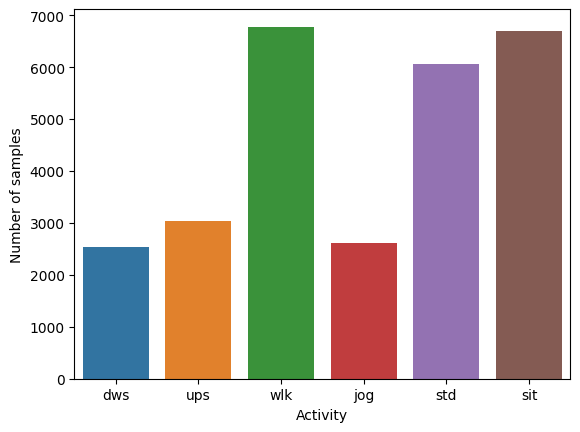

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of the number of samples per activity
def plot_act_dist(act_labels):
    """
    Args:
        act_labels: a list of activity labels.
    """
    act_dist = {}
    for act_id in act_labels:
        act_dist[ACT_LABELS[int(act_id)]] = len(subj[act_labels==act_id])
    sns.barplot(x=list(act_dist.keys()), y=list(act_dist.values()))
    plt.xlabel("Activity")
    plt.ylabel("Number of samples")
    plt.show()
    
plot_act_dist(act_labels)




In [64]:
from tensorflow import keras

def make_model(input_shape, num_classes):
    input_layer = keras.layers.Input(input_shape, name="input_layer")

    l = keras.layers.Conv1D(filters=32, kernel_size=24, activation="relu", name="conv_1")(input_layer)
    l = keras.layers.MaxPooling1D(4, 1, padding="valid", name="pool_1")(l)
    l = keras.layers.Conv1D(filters=64, kernel_size=16, activation="relu", name="conv_2")(l)
    l = keras.layers.MaxPooling1D(4, 1, padding="valid", name="pool_2")(l)
    l = keras.layers.Conv1D(filters=96, kernel_size=8, activation="relu", name="conv_3")(l)
    l = keras.layers.GlobalAveragePooling1D(name="features_layer")(l)

    output_layer = keras.layers.Dense(num_classes, activation="softmax", name="output_layer")(l)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)

model = make_model(input_shape=acc_samples[0].shape, num_classes=6)
print(model.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 100, 3)]          0         
                                                                 
 conv_1 (Conv1D)             (None, 77, 32)            2336      
                                                                 
 pool_1 (MaxPooling1D)       (None, 74, 32)            0         
                                                                 
 conv_2 (Conv1D)             (None, 59, 64)            32832     
                                                                 
 pool_2 (MaxPooling1D)       (None, 56, 64)            0         
                                                                 
 conv_3 (Conv1D)             (None, 49, 96)            49248     
                                                                 
 features_layer (GlobalAvera  (None, 96)               0   

In [65]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder()
#ohe_labels = enc.fit_transform([act_labels])
ohe_labels = enc.fit_transform(act_labels.reshape(-1,1)).toarray()

print(f"Original shape: {act_labels.shape}")
print(f"One-hot encoded shape: {ohe_labels.shape}")

print(f"From this {act_labels[0]}")
print(f"To this: {ohe_labels[0]}")

Original shape: (27712,)
One-hot encoded shape: (27712, 6)
From this 0.0
To this: [1. 0. 0. 0. 0. 0.]


In [67]:
model.compile(optimizer="adam", loss="categorical_crossentropy")

history = model.fit(
    acc_samples,
    ohe_labels,
    batch_size=128,
    epochs=30,
    verbose=1,
)

Epoch 1/30
  1/217 [..............................] - ETA: 1:23 - loss: 1.8243

2023-04-07 11:21:26.827639: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


217/217 [==============================] - 3s 14ms/step - loss: 0.6703
Epoch 2/30
217/217 [==============================] - 3s 13ms/step - loss: 0.2654
Epoch 3/30
217/217 [==============================] - 3s 14ms/step - loss: 0.1891
Epoch 4/30
217/217 [==============================] - 3s 13ms/step - loss: 0.1625
Epoch 5/30
217/217 [==============================] - 3s 14ms/step - loss: 0.1442
Epoch 6/30
217/217 [==============================] - 3s 14ms/step - loss: 0.1298
Epoch 7/30
217/217 [==============================] - 3s 13ms/step - loss: 0.1147
Epoch 8/30
217/217 [==============================] - 3s 14ms/step - loss: 0.1102
Epoch 9/30
217/217 [==============================] - 3s 14ms/step - loss: 0.1032
Epoch 10/30
217/217 [==============================] - 3s 13ms/step - loss: 0.0925
Epoch 11/30
217/217 [==============================] - 3s 13ms/step - loss: 0.0913
Epoch 12/30
217/217 [==============================] - 3s 13ms/step - loss: 0.0828
Epoch 13/30
217/217 [===

In [68]:
from sklearn.manifold import TSNE
intermediate_layer_model = keras.models.Model(inputs=model.input, outputs=model.get_layer("features_layer").output)
automatic_features = intermediate_layer_model.predict(acc_samples)

reduced_windows = TSNE(perplexity=30, verbose=1, random_state=42).fit_transform(automatic_features)

 81/866 [=>............................] - ETA: 1s

2023-04-07 11:22:55.686162: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


866/866 [==============================] - 2s 2ms/step
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 27712 samples in 0.001s...


/Users/giofratti/miniforge3/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/giofratti/miniforge3/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computed neighbors for 27712 samples in 7.907s...
[t-SNE] Computed conditional probabilities for sample 1000 / 27712
[t-SNE] Computed conditional probabilities for sample 2000 / 27712
[t-SNE] Computed conditional probabilities for sample 3000 / 27712
[t-SNE] Computed conditional probabilities for sample 4000 / 27712
[t-SNE] Computed conditional probabilities for sample 5000 / 27712
[t-SNE] Computed conditional probabilities for sample 6000 / 27712
[t-SNE] Computed conditional probabilities for sample 7000 / 27712
[t-SNE] Computed conditional probabilities for sample 8000 / 27712
[t-SNE] Computed conditional probabilities for sample 9000 / 27712
[t-SNE] Computed conditional probabilities for sample 10000 / 27712
[t-SNE] Computed conditional probabilities for sample 11000 / 27712
[t-SNE] Computed conditional probabilities for sample 12000 / 27712
[t-SNE] Computed conditional probabilities for sample 13000 / 27712
[t-SNE] Computed conditional probabilities for sample 14000 / 27712

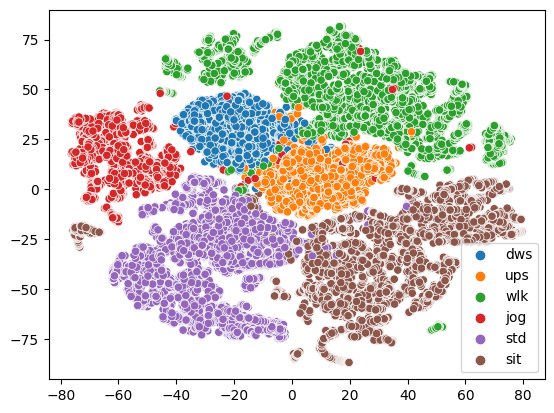

In [69]:
sns.scatterplot(x=reduced_windows[:,0], y=reduced_windows[:,1], hue=[ACT_LABELS[int(lab)] for lab in act_labels])
plt.show()